# Predicting Product Success When Review Data Is Available
_**Using XGBoost to Predict Whether Sales will Exceed the "Hit" Threshold**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
1. [Evaluation](#Evaluation)
1. [Extensions](#Extensions)


## Background

Word of mouth in the form of user reviews, critic reviews, social media comments, etc. often can provide insights about whether a product ultimately will be a success. In the video game industry in particular, reviews and ratings can have a large impact on a game's success. However, not all games with bad reviews fail, and not all games with good reviews turn out to be hits. To predict hit games, machine learning algorithms potentially can take advantage of various relevant data attributes in addition to reviews.  

For this notebook, we will work with the dataset [Video Game Sales with Ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) from Kaggle. This dataset includes data from [Metacritic](http://www.metacritic.com/browse/games/release-date/available) and other sources, with attributes for user reviews as well as critic reviews, sales, ESRB ratings, among others. Both user reviews and critic reviews are in the form of ratings scores, on a scale of 0 to 10 or 0 to 100. Although this is convenient, a significant issue with the dataset is that it is relatively small.  

Dealing with a small dataset such as this one is a common problem in machine learning. This problem often is compounded by imbalances between the classes in the small dataset. In such situations, using an ensemble learner can be a good choice.  This notebook will focus on using XGBoost, a popular ensemble learner, to build a classifier to determine whether a game will be a hit. 

## Setup


Let's start by:

- Importing various Python libraries we'll need.
- Instantiate a SageMaker session for various tasks within this notebook, and get the AWS Region.
- Specifying a S3 bucket and bucket prefix to use for training and model data.
- Defining an IAM role for S3 data access, which is pulled in from the SageMaker notebook instance.

In [1]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from sklearn.datasets import dump_svmlight_file   
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json
import boto3
import sagemaker

session = sagemaker.Session()
region = session.boto_region_name
bucket = 'fab-sagemaker'
prefix = 'sagemaker/videogames-xgboost'
role = sagemaker.get_execution_role()

print('Bucket:\n{}'.format(bucket))

Bucket:
fab-sagemaker


---
## Data

Before proceeding further, you'll need to sign in to Kaggle or create a Kaggle account if you don't have one. Then **upload the raw CSV data set from the above Kaggle link to the top level folder of the S3 bucket printed out above**. The raw_data_filename specified below is the name of the data file from Kaggle, but you should alter it if the name changes. Let's download the data from your S3 bucket to your notebook instance, where it will appear in the same directory as this notebook. Then we'll take an initial look at the data.

In [2]:
# raw_data_filename = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
s3 = boto3.resource('s3', region_name=region)
#s3.Bucket(bucket).download_file(raw_data_filename, 'raw_data.csv')
#data = pd.read_csv('./raw_data.csv')

# I manually downloaded the file from Kaggle and uploaded to this sagemaker instance notebook
data = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
pd.set_option('display.max_rows', 20) 
data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


Before proceeding further, we need to decide upon a target to predict. Video game development budgets can run into the tens of millions of dollars, so it is critical for game publishers to publish "hit" games to recoup their costs and make a profit. As a proxy for what constitutes a "hit" game, we will set a target of greater than 1 million units in global sales.

In [3]:
data['y'] = (data['Global_Sales'] > 1)

With our target now defined, let's take a look at the imbalance between the "hit" and "not a hit" classes:

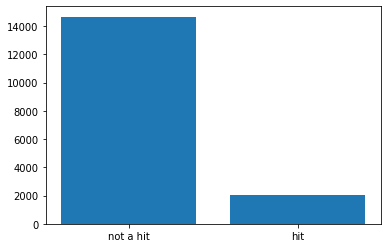

In [4]:
plt.bar(['not a hit', 'hit'], data['y'].value_counts())
plt.show()

Not surprisingly, only a small fraction of games can be considered "hits" under our metric. Next, we'll choose features that have predictive power for our target. We'll begin by plotting review scores versus global sales to check our hunch that such scores have an impact on sales. Logarithmic scale is used for clarity.

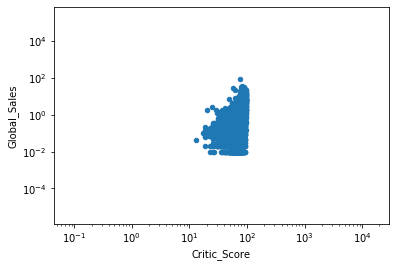

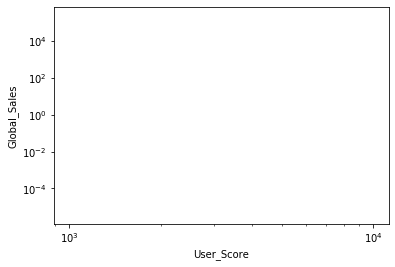

In [5]:
viz = data.filter(['User_Score','Critic_Score', 'Global_Sales'], axis=1)
viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))
viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)
viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')
plt.show()

Our intuition about the relationship between review scores and sales seems justified. We also note in passing that other relevant features can be extracted from the data set. For example, the ESRB rating has an impact since games with an "E" for everyone rating typically reach a wider audience than games with an age-restricted "M" for mature rating, though depending on another feature, the genre (such as shooter or action), M-rated games also can be huge hits. Our model hopefully will learn these relationships and others.  

Next, looking at the columns of features of this data set, we can identify several that should be excluded. For example, there are five columns that specify sales numbers: these numbers are directly related to the target we're trying to predict, so these columns should be dropped.  Other features may be irrelevant, such as the name of the game.

In [6]:
data = data.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)

With the number of columns reduced, now is a good time to check how many columns are missing data:

In [7]:
data.isnull().sum()

Platform           0
Genre              2
Publisher         54
Critic_Score    8582
User_Score      6704
Rating          6769
y                  0
dtype: int64

As noted in Kaggle's overview of this dataset, many review ratings are missing.  Unfortunately, since those are crucial features that we are relying on for our predictions, and there is no reliable way of imputing so many of them, we'll need to drop rows missing those features.

In [8]:
data = data.dropna()

Now we need to resolve a problem we see in the User_Score column: it contains some 'tbd' string values, so it obviously is not numeric. User_Score is more properly a numeric rather than categorical feature, so we'll need to convert it from string type to numeric, and temporarily fill in NaNs for the tbds. Next, we must decide what to do with these new NaNs in the User_Score column. We've already thrown out a large number of rows, so if we can salvage these rows, we should. As a first approximation, we'll take the value in the Critic_Score column and divide by 10 since the user scores tend to track the critic scores (though on a scale of 0 to 10 instead of 0 to 100).  

In [9]:
data['User_Score'] = data['User_Score'].apply(pd.to_numeric, errors='coerce')
data['User_Score'] = data['User_Score'].mask(np.isnan(data["User_Score"]), data['Critic_Score'] / 10.0)

Let's do some final preprocessing of the data, including converting the categorical features into numeric using the one-hot encoding method.

In [10]:
if data['y'].dtype == bool:
    data['y'] = data['y'].apply(lambda y: 'yes' if y == True else 'no')
model_data = pd.get_dummies(data)

To help prevent overfitting the model, we'll randomly split the data into three groups. Specifically, the model will be trained on 70% of the data. It will then be evaluated on 20% of the data to give us an estimate of the accuracy we hope to have on "new" data. As a final testing dataset, the remaining 10% will be held out until the end.

In [11]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   

Amazon SageMaker's version of XGBoost supports input data in both CSV and libSVM data format.  We'll use libSVM here, with features and the target variable provided as separate arguments. To avoid any misalignment issues due to random reordering, this split is done after the previous split in the above cell. As a last step before training, we'll copy the resulting files to S3 as input for Amazon SageMaker's hosted training.

In [12]:
dump_svmlight_file(X=train_data.drop(['y_no', 'y_yes'], axis=1), y=train_data['y_yes'], f='train.libsvm')
dump_svmlight_file(X=validation_data.drop(['y_no', 'y_yes'], axis=1), y=validation_data['y_yes'], f='validation.libsvm')
dump_svmlight_file(X=test_data.drop(['y_no', 'y_yes'], axis=1), y=test_data['y_yes'], f='test.libsvm')

s3.Bucket(bucket).Object(prefix + '/train/train.libsvm').upload_file('train.libsvm')
s3.Bucket(bucket).Object(prefix + '/validation/validation.libsvm').upload_file('validation.libsvm')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='libsvm')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='libsvm')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


---
## Train

Our data is now ready to be used to train a XGBoost model. The XGBoost algorithm has many tunable hyperparameters. Some of these hyperparameters are listed below; initially we'll only use a few of them.  

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.  The Estimator object from the Amazon SageMaker Python SDK is a convenient way to set up training jobs with a minimal amount of code.

In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='DEMO-videogames-xgboost',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=2.0,
                        num_round=100)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Next, we'll run the hosted training job itself.  The hardware used for the training job is separate from your notebook instance and is managed by Amazon SageMaker, which performs the heavy lifting such as setting up a training cluster and tearing it down when the job is done.  A single line of code starts the training job.

In [14]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-10-16 13:52:16 Starting - Starting the training job...
2020-10-16 13:52:19 Starting - Launching requested ML instances......
2020-10-16 13:53:40 Starting - Preparing the instances for training......
2020-10-16 13:54:37 Downloading - Downloading input data...
2020-10-16 13:55:15 Training - Training image download completed. Training in progress..Arguments: train
[2020-10-16:13:55:16:INFO] Running standalone xgboost training.
[2020-10-16:13:55:16:INFO] File size need to be processed in the node: 0.24mb. Available memory size in the node: 90.32mb
[13:55:16] S3DistributionType set as FullyReplicated
[13:55:16] 5614x331 matrix with 33684 entries loaded from /opt/ml/input/data/train
[13:55:16] S3DistributionType set as FullyReplicated
[13:55:16] 1604x331 matrix with 9624 entries loaded from /opt/ml/input/data/validation
[13:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]#011train-auc:0.782974#011validation-auc:0.769788
[13:

---
## Host

Now that we've trained the XGBoost algorithm on our data, we can deploy the trained model to an Amazon SageMaker hosted endpoint with one simple line of code.

In [15]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from it. More specifically, let's generate predictions from our test data set to understand how well our model generalizes to data it has not seen yet.

There are many ways to compare the performance of a machine learning model.  We'll start simply by comparing actual to predicted values of whether the game was a "hit" (`1`) or not (`0`).  Then we'll produce a  confusion matrix, which shows how many test data points were predicted by the model in each category versus how many test data points actually belonged in each category.

In [16]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [17]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

print ('\nerror rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

.........
error rate=0.134496
CPU times: user 45.6 ms, sys: 237 µs, total: 45.8 ms
Wall time: 269 ms


In [18]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

col_0,0,1
row_0,,
0,622,49
1,59,73


Of the 132 games in the test set that actually are "hits" by our metric, the model correctly identified over 70, while the overall error rate is 13%.  The amount of false negatives versus true positives can be shifted substantially in favor of true positives by increasing the hyperparameter scale_pos_weight. Of course, this increase comes at the expense of reduced accuracy/increased error rate and more false positives. How to make this trade-off ultimately is a business decision based on the relative costs of false positives, false negatives, etc.

---
## Extensions

This XGBoost model is just the starting point for predicting whether a game will be a hit based on reviews and other attributes.  There are several possible avenues for improving the model's performance.  First, of course, would be to collect more data and, if possible, fill in the existing missing fields with actual information.  Another possibility is further hyperparameter tuning using Amazon SageMaker's Automatic Model Tuning feature.  Examples of using this feature can be found in the [hyperparameter tuning directory of the SageMaker Examples GitHub repository](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning) and the **SageMaker Examples** tab of Amazon SageMaker notebook instances.  And, although ensemble learners often do well with imbalanced data sets, it could be worth exploring techniques for mitigating imbalances such as downsampling, synthetic data augmentation, and other approaches.  

---
## Cleanup

If you are finished with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [19]:
session.delete_endpoint(xgb_predictor.endpoint)